# **Hibrit Modellerle Enerji Tüketim Kestrimi**

## Kütüphanelerin Yüklenmesi ve Ayarlar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from math import sqrt

# Zaman serisi ve İstatistik kütüphaneleri
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Makine Öğrenmesi Modelleri
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Uyarıları kapatmak için (Opsiyonel)
import warnings
warnings.filterwarnings("ignore")

# Grafik stili
plt.style.use('ggplot')

## Veri Yükleme Ve Ön İşleme

In [2]:
# Verimizi içieri aktaralım ve değişken isimleri atayalım 
df = (
    pd.read_csv(r"electricityConsumptionAndProductioction.csv")
      .rename(columns={
                       "DateTime"      : "datetime", 
                       "Consumption"   : "consumption_per_hour",
                       "Production"    : "production_per_hour", 
                       "Nuclear"       : "nuclear",
                       "Wind"          : "wind", 
                       "Hydroelectric" : "hydro",
                       "Oil and Gas"   : "petrol_gas", 
                       "Coal"          : "coal",
                       "Solar"         : "solar", 
                       "Biomass"       : "biomass"
                      }
             )
)

In [3]:
# Tarih Formatı ve İndeksleme
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").set_index("datetime")
df = df.ffill()  # Eksik verileri bir önceki değerle doldur

In [4]:
# 3. Feature Engineering 
production_cols = ["nuclear", "wind", "hydro", "petrol_gas", "coal", "solar", "biomass"]
df["total_production"] = df[production_cols].sum(axis=1)
df["net_energy"] = df["total_production"] - df["consumption_per_hour"]

In [5]:
# Zaman bazlı özellikler
df["hour"] = df.index.hour
df["dow"] = df.index.dayofweek
df["is_weekend"] = df["dow"] >= 5
df.head()

,consumption_per_hour,production_per_hour,nuclear,wind,hydro,petrol_gas,coal,solar,biomass,total_production,net_energy,hour,dow,is_weekend
datetime,,,,,,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30,6527,175,0,1,False
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30,5701,-415,1,1,False
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30,5676,-197,2,1,False
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30,5603,-79,3,1,False
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30,5454,-103,4,1,False


## Veriyi Zaman Aralıklarına Göre Özetleme (Resampling)

In [6]:
num_df = df.select_dtypes(include="number")

# Aylık Ortalamalar
monthly_avg = num_df.resample("ME").mean() 
# Aylık Toplamlar
monthly_sum = num_df.resample("ME").sum()
# Haftalık Ortalamalar
weekly_avg  = num_df.resample("W").mean()

# Mevsim Bilgisi Ekleme Fonksiyonu
def get_season(month):
    if month in [12, 1, 2]: return "Kış"
    elif month in [3, 4, 5]: return "İlkbahar"
    elif month in [6, 7, 8]: return "Yaz"
    else: return "Sonbahar"

monthly_sum["season"] = monthly_sum.index.month.map(get_season)

## EDA Analizleri

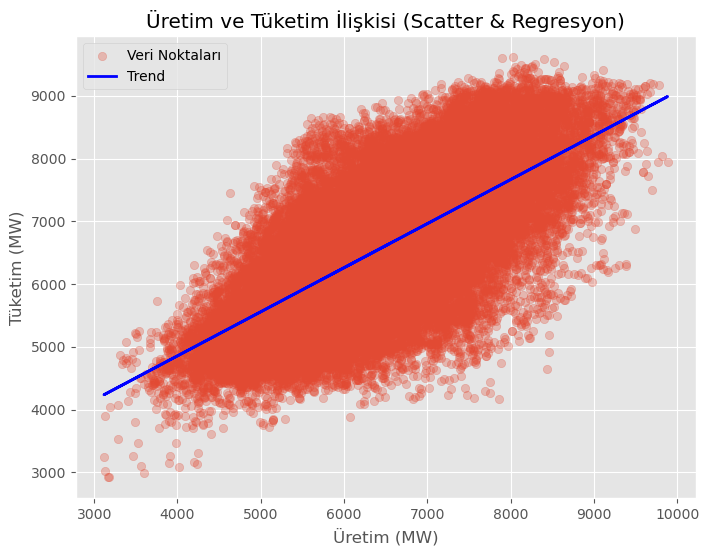

In [9]:
# Üretim vs Tüketim Regresyon Grafiği
plt.figure(figsize=(8, 6))
plt.scatter(df["total_production"], df["consumption_per_hour"], alpha=0.3, label="Veri Noktaları")
# Regresyon doğrusu
m, b = np.polyfit(df["total_production"], df["consumption_per_hour"], 1)
plt.plot(df["total_production"], m*df["total_production"] + b, color="blue", linewidth=2, label="Trend")

plt.title("Üretim ve Tüketim İlişkisi (Scatter & Regresyon)")
plt.xlabel("Üretim (MW)")
plt.ylabel("Tüketim (MW)") 
plt.legend()
plt.grid(True)
plt.show()

Grafik, üretim ile tüketimin birbirini yakından takip ettiğini gösteriyor. Bu düzenli ilişki, talep tahminlerini ve algoritmalar için büyük avanaj sağlar.

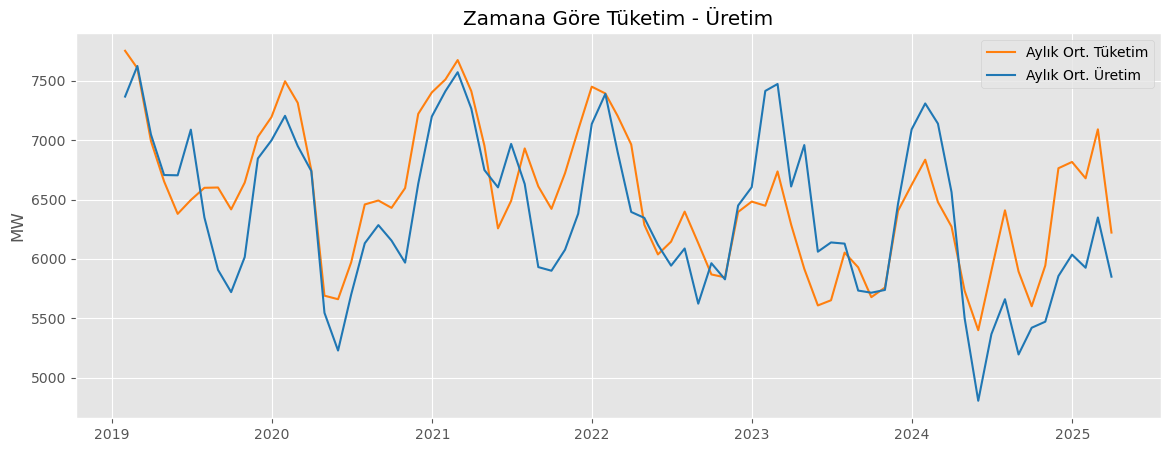

In [11]:
# Aylık Ortalama Tüketim ve Üretim Trendi
plt.figure(figsize=(14, 5))
plt.plot(monthly_avg.index, monthly_avg["consumption_per_hour"], label="Aylık Ort. Tüketim", color="tab:orange")
plt.plot(monthly_avg.index, monthly_avg["total_production"], label="Aylık Ort. Üretim", color="tab:blue")
plt.title("Zamana Göre Tüketim - Üretim")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

Üretim çoğu zaman tüketimi karşılıyor, ancak 2021 başında olduğu gibi bazı dönemlerde geride kalıyor ve bu da dışa bağımlılığı artırıyor. 2023–2024’te üretimdeki dalgalanmalar, yenilenebilir kaynakların artışı ya da planlama değişikliklerinden kaynaklanabilir. 2025’e doğru üretim ile tüketim birbirne yaklaşıyor.

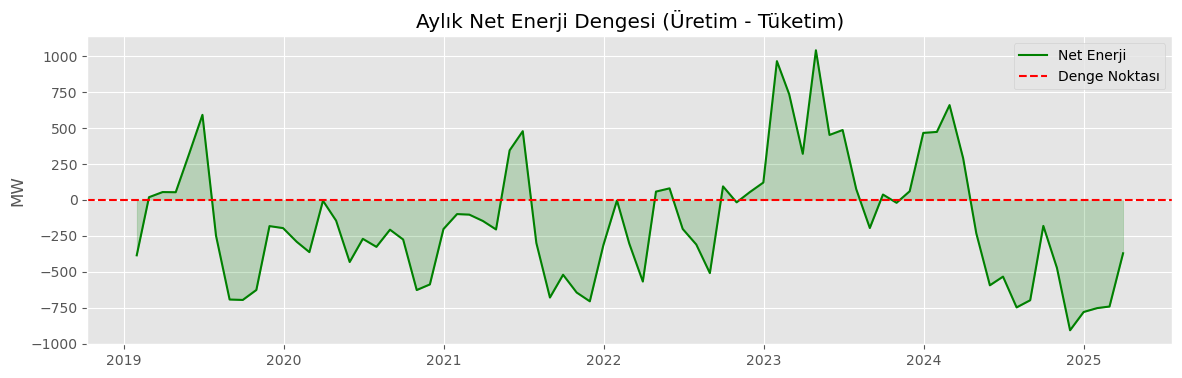

In [12]:
# 3. Net Enerji Dengesi
plt.figure(figsize=(14, 4))
plt.plot(monthly_avg.index, monthly_avg["net_energy"], color="green", label="Net Enerji")
plt.axhline(0, color="red", linestyle="--", label="Denge Noktası")
plt.fill_between(monthly_avg.index, monthly_avg["net_energy"], 0, alpha=0.2, color="green")
plt.title("Aylık Net Enerji Dengesi (Üretim - Tüketim)")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

2020–2022’de üretim genellikle tüketimi karşılıyor, hatta çoğu zaman aşıyor. 2023–2024’te ise daha sık arz açığı görülüyor; bu ya tüketimde artıştan ya da üretimdeki dalgalanmalardan kaynaklanıyor. Bu dönemde denge daha oynak hale gelmiş, muhtemelen enerji kaynaklarının çeşitlenmesiyle ilişkili.

## Enerji Kaynaklatının Analizi

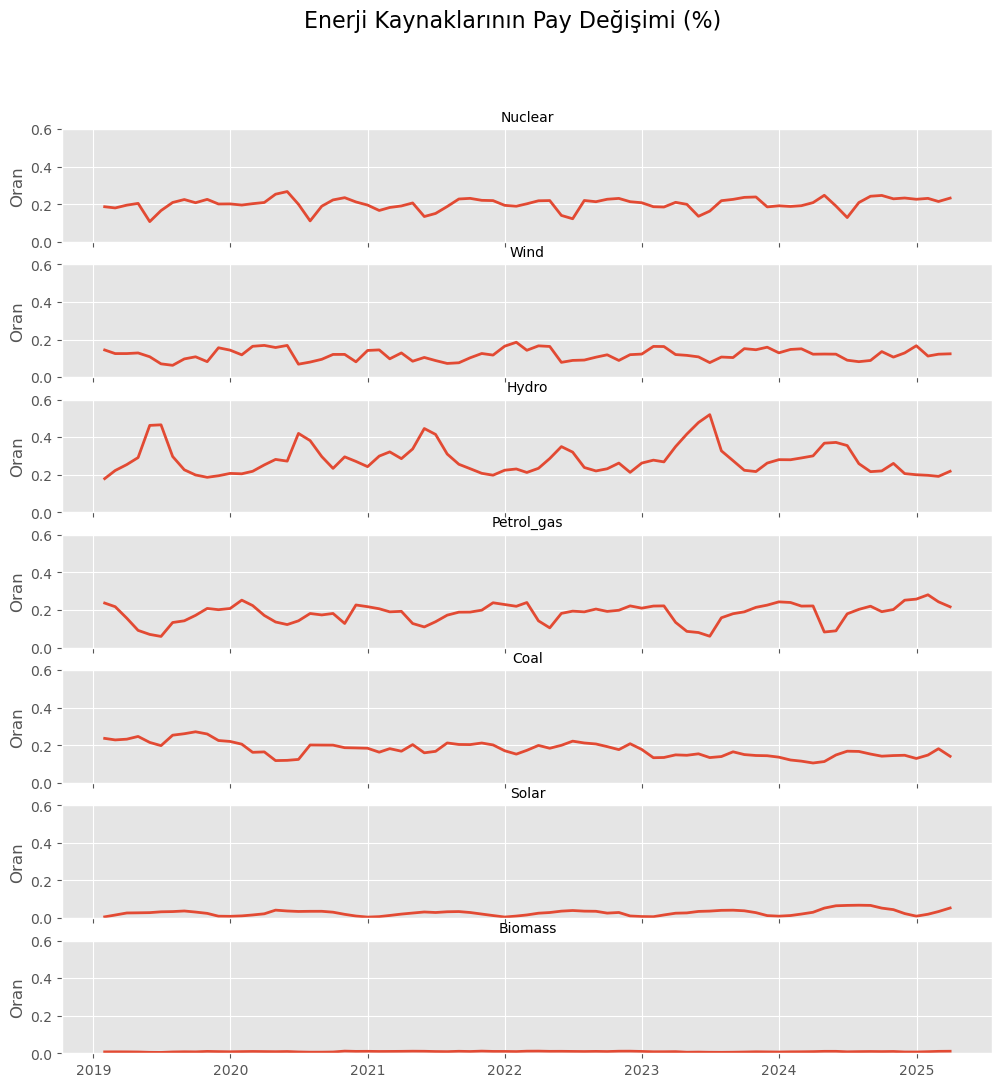

In [44]:
# Enerji Karışımı Oranları (%)
mix_pct = monthly_sum[production_cols].div(monthly_sum[production_cols].sum(axis=1), axis=0)

# 1. Kaynakların Zaman İçindeki Değişimi (Subplots)
fig, axes = plt.subplots(7, 1, figsize=(12, 12), sharex=True)
axes = axes.flatten()

# Ortak y-limit belirle (örneğin 0 ile 1 arasında)
ymin, ymax = 0, 1

for ax, col in zip(axes, production_cols):
    ax.plot(mix_pct.index, mix_pct[col], linewidth=2)
    ax.set_title(col.capitalize(), fontsize=10)
    ax.set_ylabel("Oran")
    ax.set_ylim(0,0.6)   # tüm grafiklerde aynı y aralığı

plt.suptitle("Enerji Kaynaklarının Pay Değişimi (%)", fontsize=16)
plt.tight_layout(rect=[0, 1, 1, 0.96])  # başlık ile subplotlar çakışmasın
plt.show()


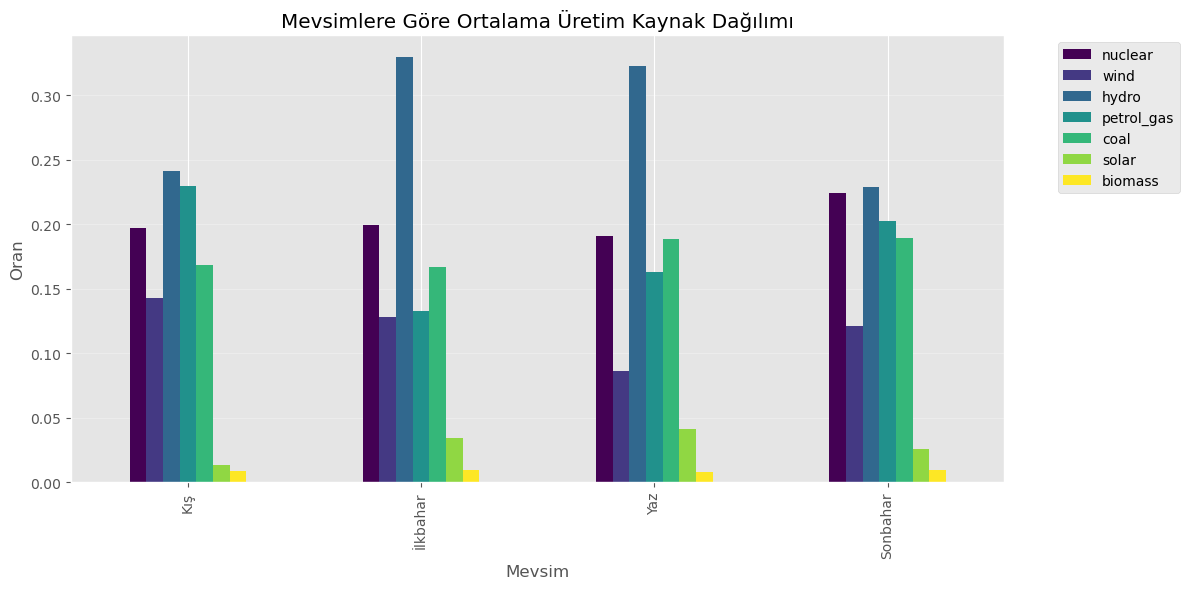

In [22]:
# Mevsimlere Göre Enerji Kaynak Dağılımı
season_index = mix_pct.index.month.map(get_season)
seasonal_mix = mix_pct.groupby(season_index).mean()
seasonal_mix = seasonal_mix.loc[["Kış", "İlkbahar", "Yaz", "Sonbahar"]] # Sıralama

seasonal_mix.plot(kind="bar", stacked=False, figsize=(12, 6), colormap="viridis")
plt.title("Mevsimlere Göre Ortalama Üretim Kaynak Dağılımı")
plt.ylabel("Oran")
plt.xlabel("Mevsim")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

- Hidro: Yaz aylarında öne çıkıyor; kar erimesi ve su rezervleriyle ilişkili.
- Nükleer: Dört mevsimde sabit ve güçlü, gerçek baz yük kaynağı.
- Rüzgar & Biyokütle: Bahar ve kışta daha yüksek, özellikle rüzgar kışın verimli.
- Kömür & Petrol/Gaz: Tüm mevsimlerde düşüşte, katkısı düşük; sürdürülebilirlik adımlarının etkisi olabilir.
- Güneş: Yazın zirvede, diğer mevsimlerde sınırlı.


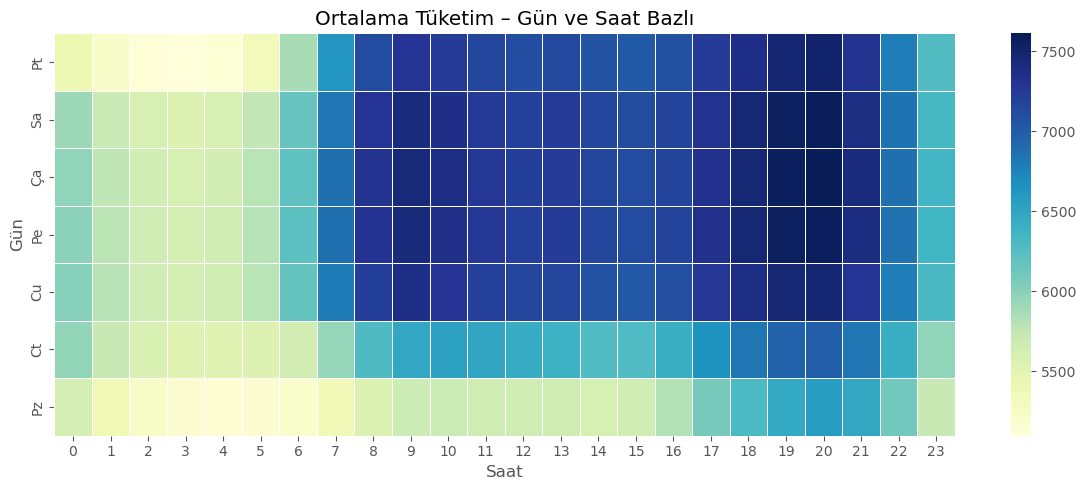

In [46]:
# Gün ve saat bazlı tüketim 
pivot = df.pivot_table(index="dow", columns="hour", values="consumption_per_hour", aggfunc="mean")
pivot.index = ["Pt", "Sa", "Ça", "Pe", "Cu", "Ct", "Pz"]

plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5, linecolor="white")
plt.title("Ortalama Tüketim – Gün ve Saat Bazlı")
plt.ylabel("Gün")
plt.xlabel("Saat")
plt.tight_layout()
plt.show()


Hafta içi sabah 08:00’den itibaren tüketim artmakta, öğleden sonra zirveye ulaşıp gece düşmektedir. Hafta sonları ise genel tüketim daha düşük seyretmektedir. Bu desen, mesai saatlerine bağlı enerji talep alışkanlıklarını yansıtmaktadır.

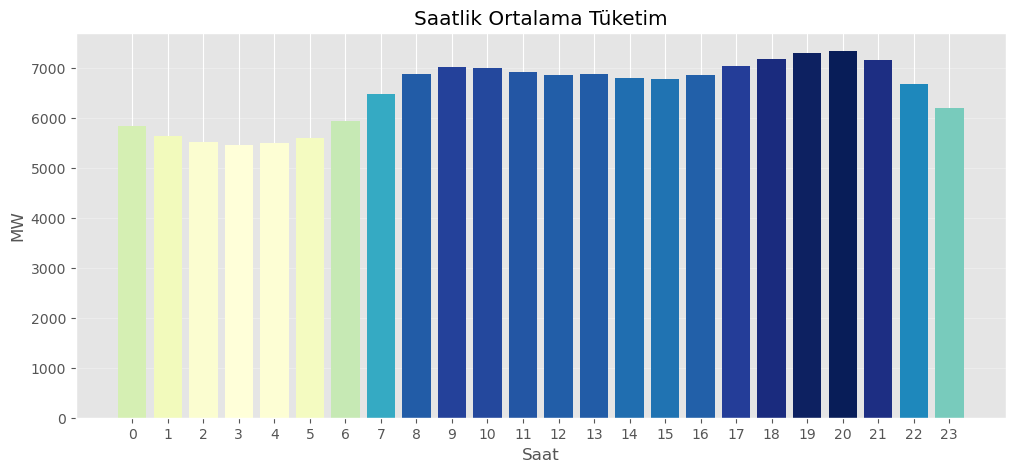

In [54]:
hourly_avg = df.groupby("hour")["consumption_per_hour"].mean()
norm = mcolors.Normalize(vmin=hourly_avg.min(), vmax=hourly_avg.max())
colormap = cm.get_cmap("YlGnBu")
bar_colors = colormap(norm(hourly_avg.values))
# ---------------------------

plt.figure(figsize=(12, 5))
plt.bar(hourly_avg.index, hourly_avg.values, color=bar_colors)
plt.title("Saatlik Ortalama Tüketim")
plt.xlabel("Saat")
plt.ylabel("MW")
plt.xticks(range(0, 24)) 
plt.grid(axis="y", alpha=0.3)
plt.show()


Günlük Tüketim Deseni ve Yoğun Saatler: Elektrik tüketimi gece 03:00–06:00 arasında minimum düzeyde seyrediyor. Bu, düşük nüfus hareketi ve sanayi faaliyetlerinin azlığıyla ilişkili. Sabah 07:00’den itibaren tüketim hızla artıyor, ardından gün boyunca yüksek seviyede kalıyor. Özellikle 08:00 ile 21:00 saatleri arasında tüketim 7000 MW'ın üzerinde seyrediyor. Bu süre zarfı, enerji sistemine en fazla yük binen dönem.

# İstatistiksel Analiz ve Anomali Tespiti

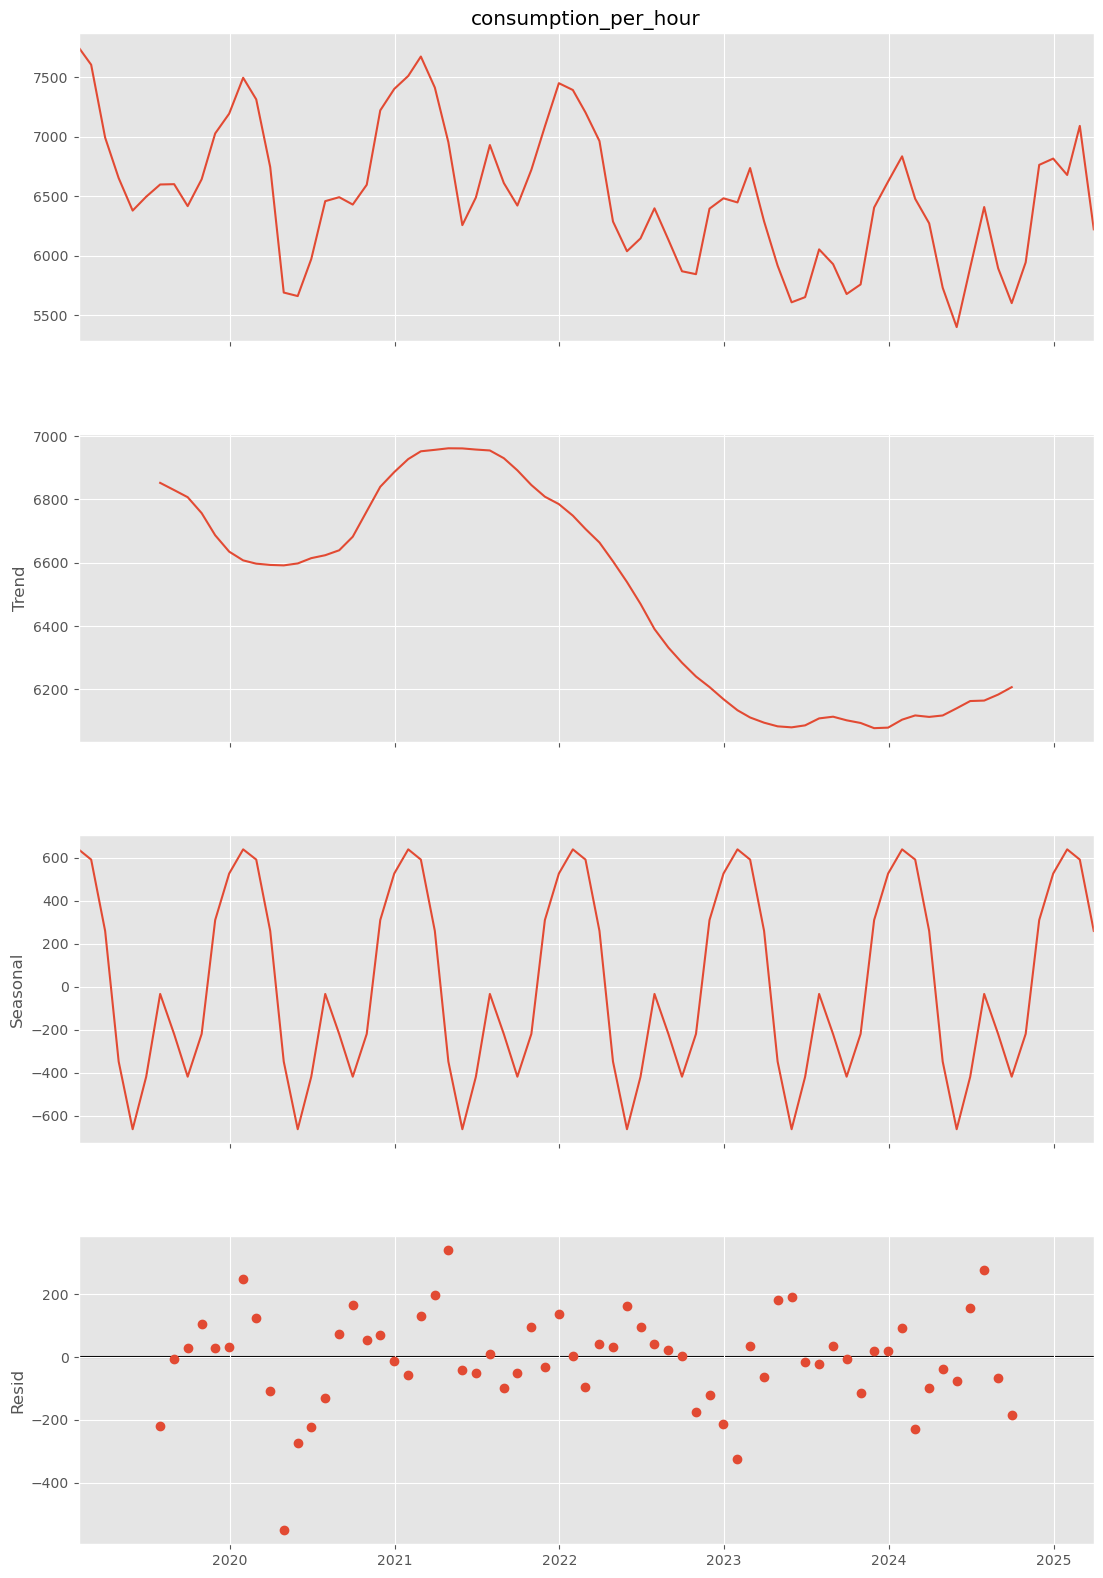

In [55]:
# 1. Zaman Serisi Ayrıştırma (Decomposition)
# Trend, Mevsimsellik ve Artık (Residual) bileşenleri
res = seasonal_decompose(monthly_avg["consumption_per_hour"], model="additive")
fig = res.plot()
fig.set_size_inches(12, 18)
plt.show()

- Gözlemlenen: Saatlik ortalama tüketimde her yıl tekrar eden tepe ve dipler var; güçlü mevsimsellik etkisi dikkat çekiyor.
- Trend: 2020–2023 arasında hafif yükseliş, 2024’te dalgalanma; ekonomik toparlanma ve sanayi tüketimiyle ilişkili olabilir.
- Mevsimsel: Kış aylarında zirve, yaz aylarında düşüş; ısınma ihtiyacı belirleyici faktör.
- Residual: Trend ve mevsimsellikten bağımsız ani sapmalar; 2023 ortası ve 2025 başındaki dalgalanmalar olağandışı hava veya ekonomik koşullarla açıklanabilir.

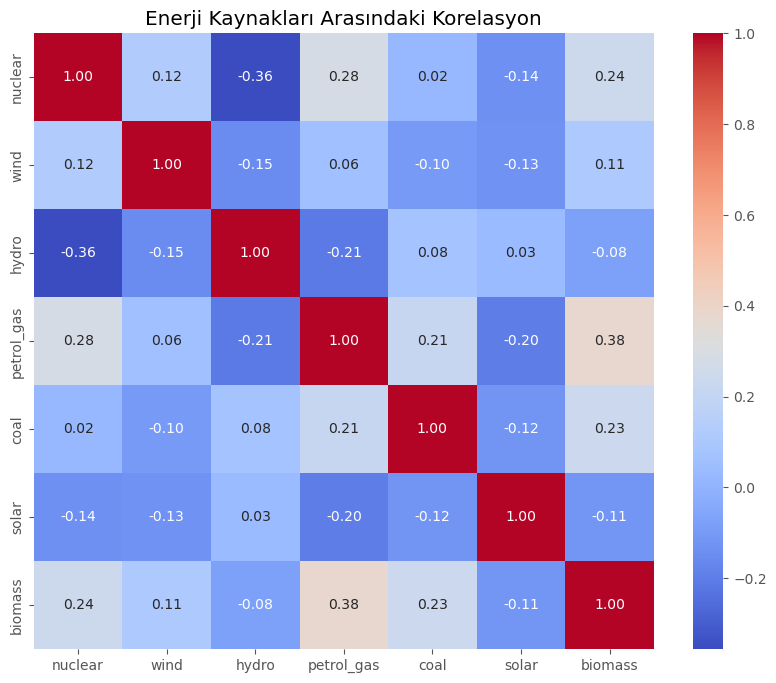

In [24]:
# Korelasyon Matrisi
plt.figure(figsize=(10, 8))
sns.heatmap(df[production_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Enerji Kaynakları Arasındaki Korelasyon")
plt.show()

- Nükleer ↔ Hidro (-0.36): Negatif ilişki; biri yüksekken diğeri düşük. Şebeke dengesini sağlamak için birbirini tamamlıyor olabilir.
- Petrol/Gaz ↔ Biyokütle (0.38): En güçlü pozitif korelasyon; aynı dönemlerde birlikte artış gösteriyor, esnek kaynaklar gibi çalışıyor.
- Güneş: Diğer kaynaklarla zayıf ve negatif korelasyon; üretim deseni bağımsız, öğlen saatlerine özgü.
- Kömür ↔ Petrol/Gaz (0.21): Ilımlı pozitif ilişki; fosil yakıt üretimi aynı talep/politika dönemlerinde artıyor olabilir.
- Rüzgar: Tüm kaynaklarla zayıf korelasyon; doğa koşullarına bağlı, öngörüsü daha zor.


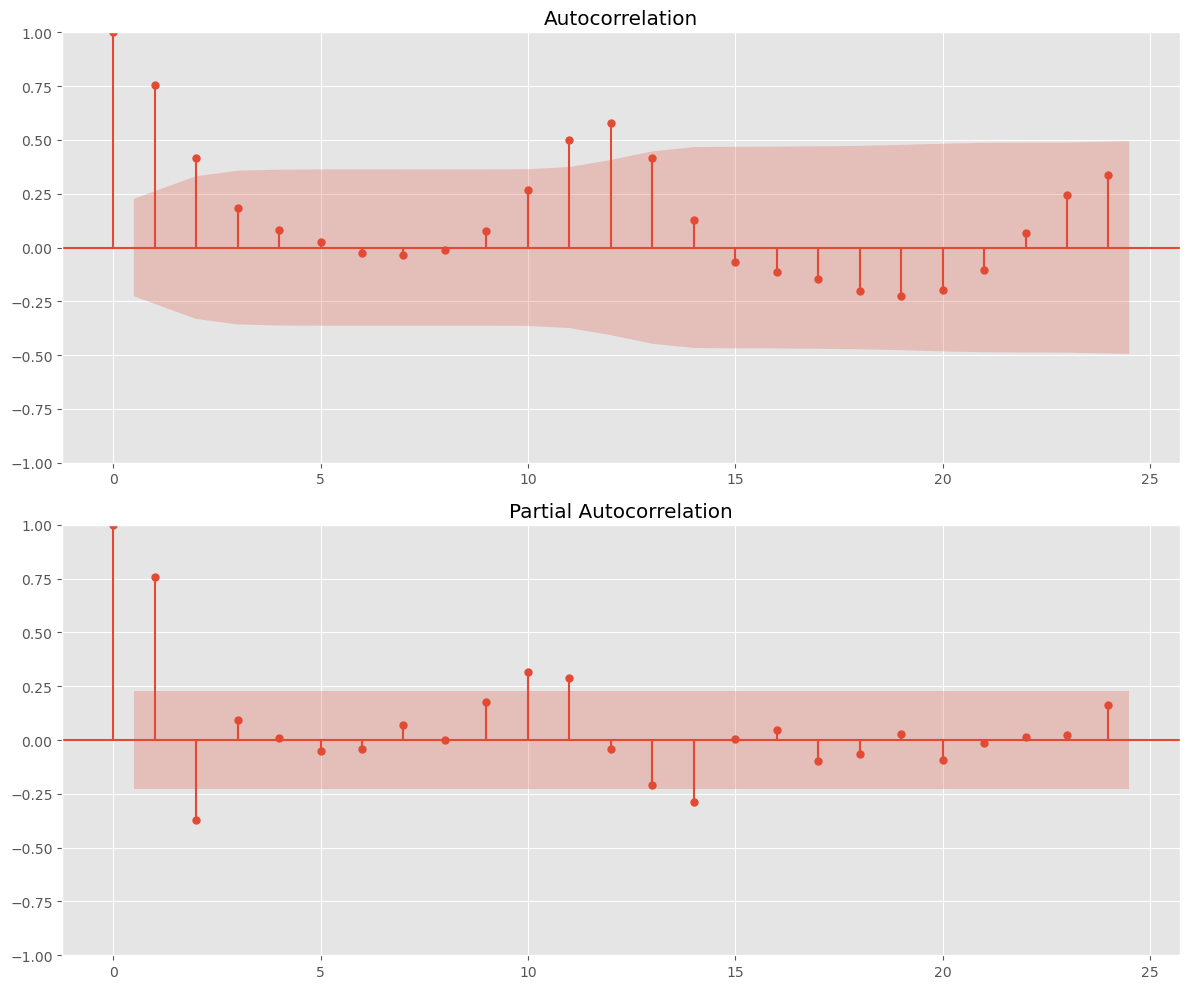

In [30]:
# Otokorelasyon (ACF) ve Kısmi Otokorelasyon (PACF)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(monthly_avg["consumption_per_hour"], lags=24, ax=ax1)
plot_pacf(monthly_avg["consumption_per_hour"], lags=24, ax=ax2)
plt.tight_layout()
plt.show()

- ACF: İlk birkaç gecikmede güçlü pozitif otokorelasyon var; tüketim geçmiş değerlerden etkileniyor. Lag 1–4 kısa vadeli sürekliliği, Lag 12 ise yıllık mevsimselliği işaret ediyor.
- PACF: Lag 1 çok güçlü; sonraki gecikmeler zayıf. Bu yapı AR(1) tipi modellerin uygun olabileceğini gösteriyor.
- Genel: Grafikler, serinin düzenli ve tahmine elverişli olduğunu ortaya koyuyor. Prophet gibi trend + mevsimsellik modelleri veya klasik ARIMA yaklaşımları bu veriyle çalışabilir. Gecikmeli etkiler, tüketimde tekrar eden davranışları yansıtıyor.


In [31]:
# 4. Anomali Tespiti (Isolation Forest)
# Haftalık verideki aykırı değerleri bulalım
iso = IsolationForest(contamination=0.01, random_state=42)
weekly_avg["anomaly"] = iso.fit_predict(weekly_avg[["consumption_per_hour"]]) == -1

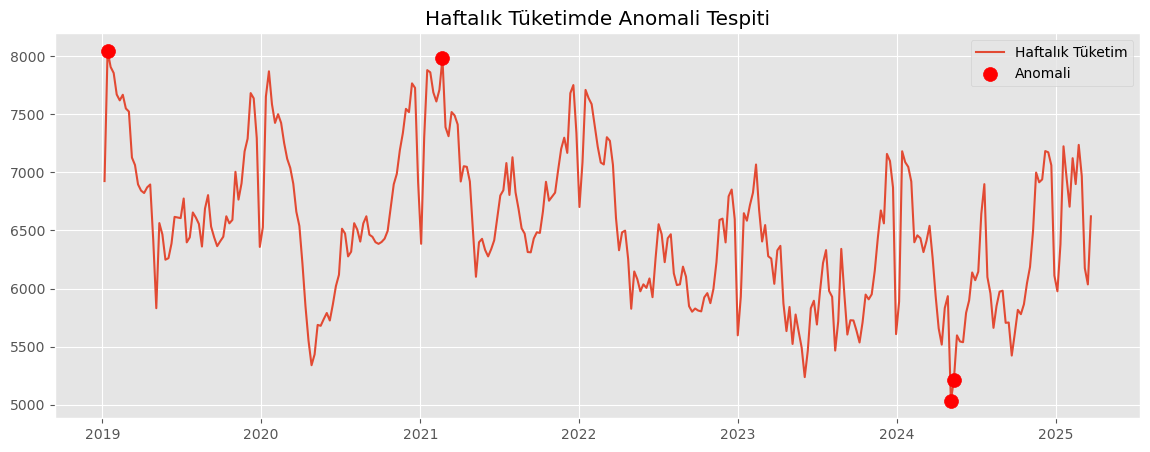

In [32]:
# Anomalileri Görselleştirme
plt.figure(figsize=(14, 5))
plt.plot(weekly_avg.index, weekly_avg["consumption_per_hour"], label="Haftalık Tüketim")
anomalies = weekly_avg[weekly_avg["anomaly"]]
plt.scatter(anomalies.index, anomalies["consumption_per_hour"], color="red", s=100, label="Anomali", zorder=5)
plt.title("Haftalık Tüketimde Anomali Tespiti")
plt.legend()
plt.show()

Tüketim verisi üzerinde yapılan haftalık anomali analizinde, beklenmedik sapma gösteren haftalar tespit edilmiştir. Bu haftalar olağandışı talep artışı veya düşüşü gibi özel koşullara işaret edebilir.

## Tahmin Modelleri (Forecasting) Fonksiyonları

In [34]:
# Tahmin Fonksiyonları

def prophet_forecast(train, periods, holidays_df=None):
    df_train = train.reset_index()
    df_train.columns = ["ds", "y"]
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays_df)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=periods, freq="M")
    forecast = m.predict(future)
    return forecast.iloc[-periods:]["yhat"].values

def arima_forecast(train, periods):
    # Basit bir (1,1,1) order kullanıldı, optimize edilebilir.
    model = ARIMA(train, order=(1,1,1)).fit()
    forecast = model.forecast(steps=periods)
    return forecast.values

def holtwinters_forecast(train, periods, trend_type="add", seasonal_type="add", seasonal_periods=12):
    model = ExponentialSmoothing(train, trend=trend_type, seasonal=seasonal_type, seasonal_periods=seasonal_periods).fit()
    forecast = model.forecast(periods)
    return forecast.values

# Makine öğrenmesi modelleri için veriyi hazırlayan yardımcı fonksiyon
def feature_engineering_ml(series):
    df = series.to_frame(name="y")
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["time_idx"] = np.arange(len(df))
    return df

def ml_forecast(train, test, model_type="rf"):
    train_fe = feature_engineering_ml(train)
    test_fe = feature_engineering_ml(test)

    features = ["time_idx", "month", "quarter", "year"]

    if model_type == "rf":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == "xgb":
        model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    else:
        raise ValueError("model_type must be 'rf' or 'xgb'")

    model.fit(train_fe[features], train_fe["y"])
    preds = model.predict(test_fe[features])
    return preds

In [35]:
# Veriyi Hazırla (Son 6 ayı test olarak ayırıyoruz)
ts = monthly_avg["consumption_per_hour"]
test_months = 6
train, test = ts[:-test_months], ts[-test_months:]

# Modelleri Çalıştır ve Sonuçları Topla
results = {}
results["Prophet"] = prophet_forecast(train, periods=len(test))
results["ARIMA"] = arima_forecast(train, periods=len(test))
results["Holt-Winters (Add)"] = holtwinters_forecast(train, periods=len(test), trend_type="add", seasonal_type="add")
results["RandomForest"] = ml_forecast(train, test, model_type="rf")
results["XGBoost"] = ml_forecast(train, test, model_type="xgb")

# Performans Metriklerini Hesapla
metrics = {"Model": [], "MSE": [], "RMSE": [], "MAE": []}

for model_name, preds in results.items():
    mse = mean_squared_error(test, preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(test, preds)
    metrics["Model"].append(model_name)
    metrics["MSE"].append(mse)
    metrics["RMSE"].append(rmse)
    metrics["MAE"].append(mae)

11:28:46 - cmdstanpy - INFO - Chain [1] start processing
11:28:47 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Tabloyu Göster
metrics_df = pd.DataFrame(metrics).set_index("Model").sort_values("RMSE")
print("\n--- Model Performans Karşılaştırması (Test Seti) ---\n")
print(metrics_df.round(2))


--- Model Performans Karşılaştırması (Test Seti) ---

                           MSE     RMSE     MAE
Model                                          
Prophet               57902.82   240.63  217.20
Holt-Winters (Add)   110983.75   333.14  275.23
RandomForest         284829.64   533.69  474.80
XGBoost              383950.02   619.64  562.23
ARIMA               1089897.35  1043.98  970.08


- Prophet, mevsimsellik ve trend yapısını en iyi öğrenen model olmayı başarmış.

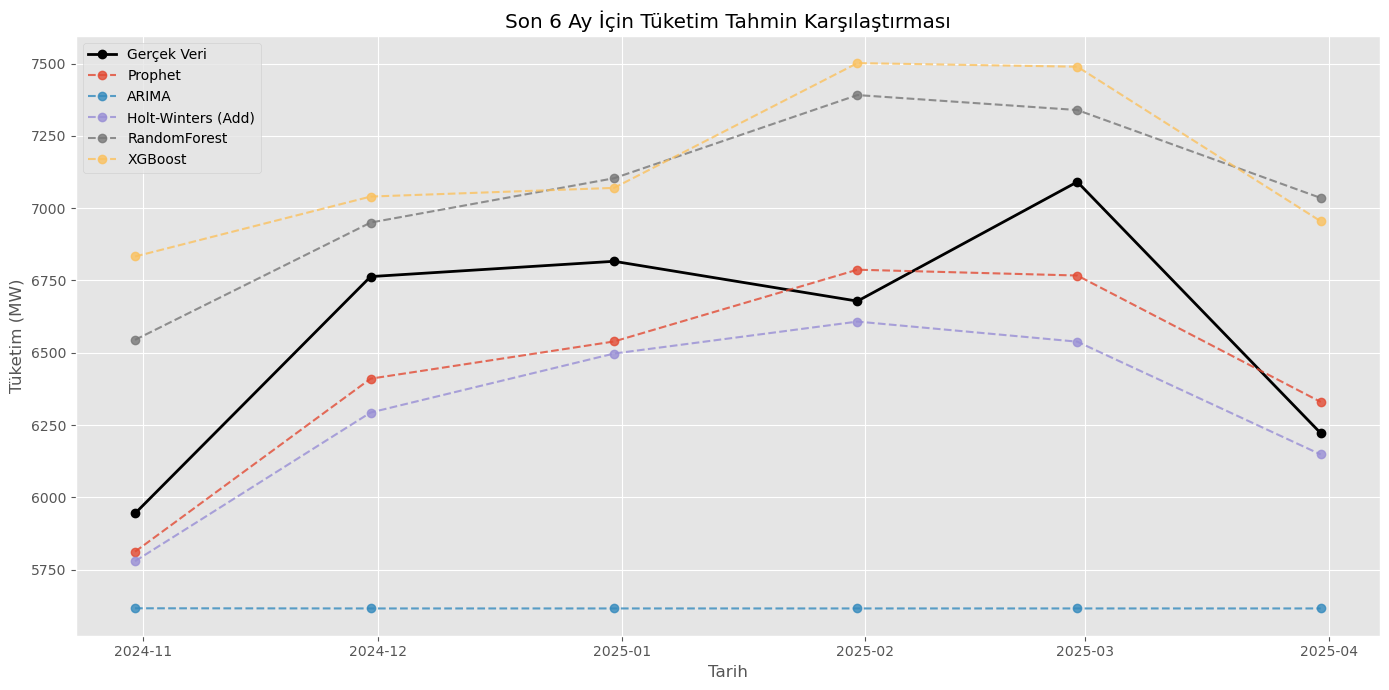

In [40]:
# Karşılaştırma Grafiği
plt.figure(figsize=(14, 7))
plt.plot(test.index, test.values, label="Gerçek Veri", color="black", marker="o", linewidth=2)

colors = sns.color_palette("tab10", n_colors=len(results))
for (model_name, preds), color in zip(results.items(), colors):
    plt.plot(test.index, preds, label=model_name, marker="o", linestyle="--", alpha=0.8)

plt.title(f"Son {test_months} Ay İçin Tüketim Tahmin Karşılaştırması")
plt.xlabel("Tarih")
plt.ylabel("Tüketim (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Prophet  ve Gerçek veriler oldukça uyumlu görünüyor. Tahminler gerçek tüketim desenini başarıyla takip ediyor.
- Holt-Winters: Genel eğilimi yakalıyor ama uç değerlerde Prophet kadar sağlam değil.
- ARIMA: En fazla sapmayı gösteriyor; tahminler gerçek veriden uzaklaşıyor.
- Random Forest & XGBoost: Bazı dönemleri iyi yakalasa da dalgalı ve mevsimsel ritmi tam takip edemiyor.

## Geleceğe Yönelik Nihai Tahmin

In [42]:
# Tüm veriyi kullanarak Prophet modelini eğit
df_prop = monthly_avg.reset_index()[["datetime", "consumption_per_hour"]]
df_prop.columns = ["ds", "y"]

m_final = Prophet(yearly_seasonality=True)
m_final.fit(df_prop)

# Gelecek 12 ay için dataframe oluştur
future = m_final.make_future_dataframe(periods=12, freq="M")
forecast = m_final.predict(future)



11:31:48 - cmdstanpy - INFO - Chain [1] start processing
11:31:48 - cmdstanpy - INFO - Chain [1] done processing


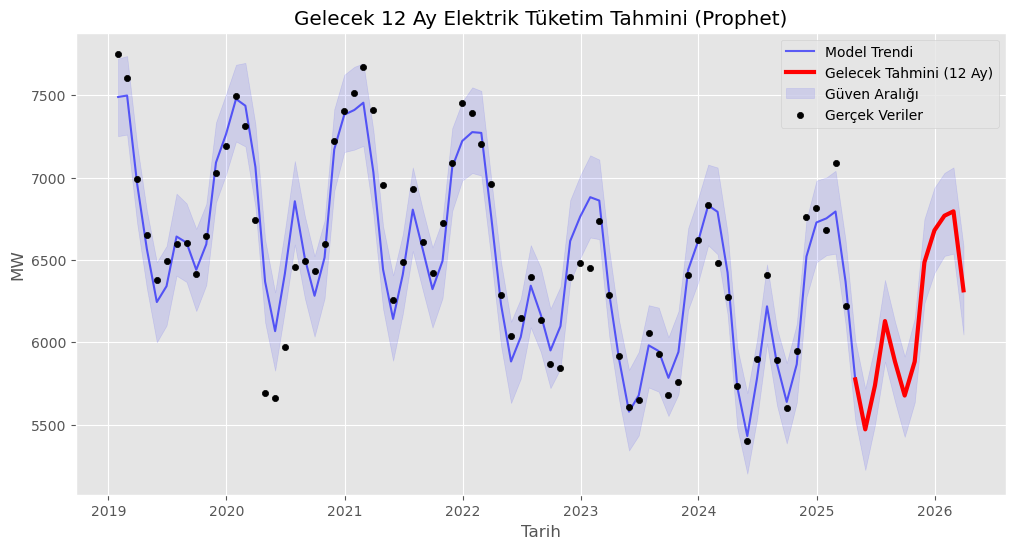

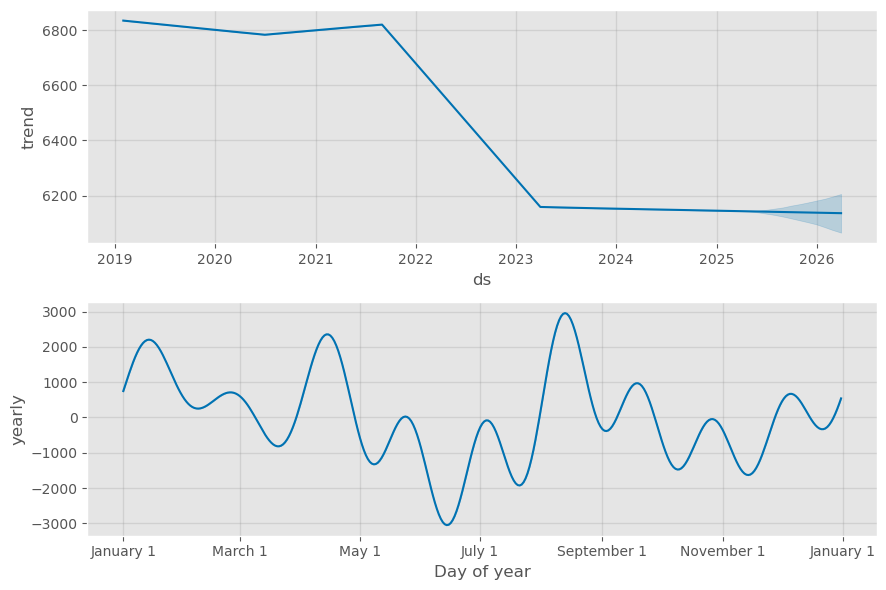

In [43]:
# Sonuçları Görselleştir
plt.figure(figsize=(12, 6))

# Geçmiş (Tahmin edilen)
plt.plot(forecast["ds"], forecast["yhat"], color="blue", label="Model Trendi", alpha=0.6)

# Gelecek Tahmini (Kırmızı)
future_mask = forecast["ds"] > df_prop["ds"].max()
plt.plot(forecast[future_mask]["ds"], forecast[future_mask]["yhat"], 
         color="red", linewidth=3, label="Gelecek Tahmini (12 Ay)")

# Güven Aralığı
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color="blue", alpha=0.1, label="Güven Aralığı")

# Gerçek Veriler
plt.scatter(df_prop["ds"], df_prop["y"], color="black", s=20, label="Gerçek Veriler", zorder=3)

plt.title("Gelecek 12 Ay Elektrik Tüketim Tahmini (Prophet)")
plt.xlabel("Tarih")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Prophet'in kendi bileşen grafiği (Trend, Mevsimsellik)
m_final.plot_components(forecast)
plt.show()

## Sonuç Ve Değerlendirme

Bu projede, Romanya’nın Mart 2019 – Mart 2025 arasındaki saatlik elektrik üretim ve tüketim verileri incelenmiştir. Yenilenebilir ve konvansiyonel kaynakların mevsimsel ve yapısal dinamikleri analiz edilerek üretim–tüketim dengesi, kaynak çeşitliliği, arz güvenliği ve sürdürülebilirlik üzerine önemli içgörüler elde edilmiştir.

Zaman serisi modelleri (Prophet, ARIMA, Holt-Winters) ve makine öğrenimi yöntemleri (Random Forest, XGBoost) kullanılarak geleceğe yönelik tahminler yapılmıştır. Prophet modeli, mevsimselliği en iyi şekilde yakalayarak en düşük hata oranıyla öne çıkmıştır.

Sonuç olarak, proje hem geçmişin dinamiklerini hem de geleceğe yönelik planlama stratejilerini şekillendirmiş; enerji arz-talep dengesinin daha verimli, öngörülebilir ve sürdürülebilir hale gelmesine katkı sağlamıştır.